<a href="https://colab.research.google.com/github/dileepyadavns/multivaraiate_time_series_forecasting/blob/main/forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import matplotlib.pyplot as plt
# from pandas import read_csv
# from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM

In [ ]:
dataset_train = pd.read_csv('/content/train.csv',header=0, index_col=0)  
dataset_train.head(2)

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
03-01-2015 01:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
03-01-2015 02:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0


In [ ]:
print(type(dataset_train))
dataset_train.shape

<class 'pandas.core.frame.DataFrame'>


(43775, 16)

In [ ]:
dataset_columns = dataset_train.columns.tolist()
dataset_columns

['nat_demand',
 'T2M_toc',
 'QV2M_toc',
 'TQL_toc',
 'W2M_toc',
 'T2M_san',
 'QV2M_san',
 'TQL_san',
 'W2M_san',
 'T2M_dav',
 'QV2M_dav',
 'TQL_dav',
 'W2M_dav',
 'Holiday_ID',
 'holiday',
 'school']

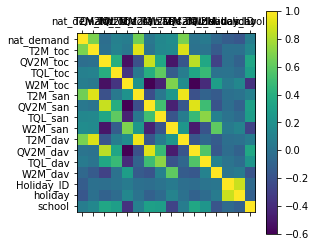

In [ ]:
cor_cols = dataset_columns
plt.matshow(dataset_train.corr())
plt.xticks(range(len(cor_cols)), cor_cols)
plt.yticks(range(len(cor_cols)), cor_cols)
plt.colorbar()
plt.show()

In [ ]:
values = dataset_train.values
print(values.shape)
print(type(values))
values[0]

(43775, 16)
<class 'numpy.ndarray'>


array([9.70345000e+02, 2.58652588e+01, 1.85763820e-02, 1.61743160e-02,
       2.18505458e+01, 2.34824463e+01, 1.72717550e-02, 1.85537300e-03,
       1.03289487e+01, 2.26621338e+01, 1.65622220e-02, 9.60998500e-02,
       5.36414795e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [ ]:
# normalized the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)
scaled_dataset[0]

array([0.5409399 , 0.24092133, 0.61321832, 0.03103044, 0.55688809,
       0.19262007, 0.59236179, 0.00380735, 0.42043586, 0.19103092,
       0.61106557, 0.20105082, 0.52063079, 0.        , 0.        ,
       0.        ])

In [ ]:
def to_supervised(train):
  window_size = 4
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i-window_size:i,:])
    Y.append(train[i,0:1])
    
  return X,Y
X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)

Y (43771, 1)
X (43771, 4, 16)


In [ ]:
X[0][0]

array([0.5409399 , 0.24092133, 0.61321832, 0.03103044, 0.55688809,
       0.19262007, 0.59236179, 0.00380735, 0.42043586, 0.19103092,
       0.61106557, 0.20105082, 0.52063079, 0.        , 0.        ,
       0.        ])

In [ ]:
X[0][1]

array([0.50539099, 0.24373419, 0.62044905, 0.03149883, 0.56495521,
       0.18830926, 0.5917586 , 0.00271794, 0.43487148, 0.18520624,
       0.60639517, 0.18335602, 0.54090872, 0.        , 0.        ,
       0.        ])

In [ ]:
X[0][2]

array([0.49811449, 0.24688035, 0.63122022, 0.02969848, 0.57229741,
       0.18542169, 0.58717608, 0.00292638, 0.44279035, 0.18185159,
       0.60370644, 0.16470301, 0.569985  , 0.        , 0.        ,
       0.        ])

In [ ]:
X[0][3]

array([0.49181073, 0.24855696, 0.64270863, 0.03122073, 0.56351557,
       0.17999443, 0.5799688 , 0.00534018, 0.4282018 , 0.18053538,
       0.60439262, 0.14304764, 0.57119564, 0.        , 0.        ,
       0.        ])

In [ ]:
#Splitting the dataset
n_train = 24*365
train_X, test_X = X[n_train:,] , X[:n_train,]
print('train_X' ,train_X.shape)
print('test_X' ,test_X.shape)

train_y, test_y = Y[n_train:,] , Y[:n_train,]
print('train_y' ,train_y.shape)
print('test_y' ,test_y.shape)

train_X (35011, 4, 16)
test_X (8760, 4, 16)
train_y (35011, 1)
test_y (8760, 1)


In [ ]:
train_y

array([[0.4973438 ],
       [0.47749485],
       [0.48078521],
       ...,
       [0.67742589],
       [0.63878884],
       [0.61068694]])

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(units = 1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
487/487 - 5s - loss: 0.0835 - val_loss: 0.0869 - 5s/epoch - 11ms/step
Epoch 2/50
487/487 - 2s - loss: 0.0581 - val_loss: 0.0492 - 2s/epoch - 5ms/step
Epoch 3/50
487/487 - 2s - loss: 0.0507 - val_loss: 0.0417 - 2s/epoch - 4ms/step
Epoch 4/50
487/487 - 2s - loss: 0.0444 - val_loss: 0.0300 - 2s/epoch - 4ms/step
Epoch 5/50
487/487 - 2s - loss: 0.0384 - val_loss: 0.0315 - 2s/epoch - 4ms/step
Epoch 6/50
487/487 - 2s - loss: 0.0337 - val_loss: 0.0258 - 2s/epoch - 4ms/step
Epoch 7/50
487/487 - 2s - loss: 0.0309 - val_loss: 0.0330 - 2s/epoch - 4ms/step
Epoch 8/50
487/487 - 2s - loss: 0.0281 - val_loss: 0.0319 - 2s/epoch - 4ms/step
Epoch 9/50
487/487 - 2s - loss: 0.0262 - val_loss: 0.0243 - 2s/epoch - 4ms/step
Epoch 10/50
487/487 - 2s - loss: 0.0248 - val_loss: 0.0259 - 2s/epoch - 4ms/step
Epoch 11/50
487/487 - 2s - loss: 0.0234 - val_loss: 0.0207 - 2s/epoch - 4ms/step
Epoch 12/50
487/487 - 2s - loss: 0.0229 - val_loss: 0.0375 - 2s/epoch - 4ms/step
Epoch 13/50
487/487 - 2s - loss: 0.0

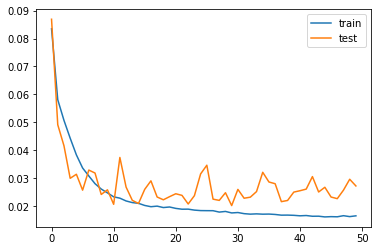

In [ ]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
Y_pred = model.predict(test_X)

mse = mean_squared_error(test_y, Y_pred)

rmse = np.sqrt(mse)
rmse

0.03214026757249467

In [ ]:
d = scaled_dataset[:8760,:]
Y_predicted = np.concatenate((Y_pred,d[:8760,1:]), axis =1)
print('concat y_pred',Y_pred.shape)
Y_tested = np.concatenate((test_y, d[:8760,1:]), axis = 1)
print('concat Y_test', test_y.shape)

concat y_pred (8760, 1)
concat Y_test (8760, 1)


In [ ]:
#Scaling back to the original scale
Y_predicted = scaler.inverse_transform(Y_predicted)
Y_tested = scaler.inverse_transform(Y_tested)
Y_predicted = Y_predicted[:,0:1]
Y_tested = Y_tested[:,0:1]
print('Y_tested', Y_tested.shape)
print('Y_predicted', Y_predicted.shape)

Y_tested (8760, 1)
Y_predicted (8760, 1)


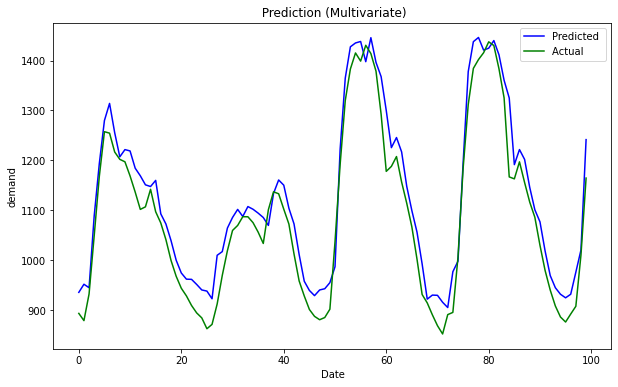

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plot the graph between actual vs predicted values
pyplot.figure(figsize=(10,6))  
pyplot.plot(Y_predicted[:100,:], color= 'blue',label = 'Predicted ')
pyplot.plot(Y_tested[:100,:] , color = 'green',label = 'Actual ')
pyplot.title(" Prediction (Multivariate)")
pyplot.xlabel("Date")
pyplot.ylabel("demand")
pyplot.legend()
pyplot.show()
pyplot.savefig('graph.png')